#### All Imports

In [1]:
import os
import cv2
import dlib
import sys
from collections import OrderedDict
import imutils
from imutils import face_utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report,accuracy_score, f1_score, roc_auc_score, roc_curve, auc
import tensorflow as tf

Using TensorFlow backend.


### Utility Functions

In [53]:
def read_image_dataset(img_path):
    """
    Input Params: Path to images
    Returns a list of image paths which will be our dataset.
    """

    w = "with_mask"
    wo = "without_mask"
    with_mask = os.listdir(os.path.join(img_path, w))
    without_mask = os.listdir(os.path.join(img_path, wo))
    images = [os.path.join(img_path, w, name) for name in with_mask if ".jpg" in name or ".png" in name][:3000] # Considering 3000 Images for both classes.
    images.extend([os.path.join(img_path, wo, name) for name in without_mask if ".jpg" in name or ".png" in name][:3000])
    
    return images

In [54]:
def get_cascades():
    # Create Cascade Classifiers for face, eyes, nose and mouth from Opencv Haarcascade classifiers
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    nose_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_nose.xml')
    mouth_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_mcs_mouth.xml')
    
    return face_cascade, eye_cascade, nose_cascade, mouth_cascade

In [55]:
def create_dataset(images):
    """
    Creates and Returns Dataset X, Y where X contains training images (96, 96, 3) along with 3 additional features - eyes, nose and mouth (1 indicates feature is present in image)
    and Y is the label (1 for with_mask, 0 for without mask)
    """
    
    # Add all features to this list, and create a df from it later
    feature_list = []
    for i in range(len(images)):
        temp = []
        image = images[i]

        img = cv2.imread(image)

        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Create cascade classifiers
        face_cascade, eye_cascade, nose_cascade, mouth_cascade = get_cascades()
        
        # Detect eys, nose and mouth in image
        eyes = eye_cascade.detectMultiScale(img_gray, 1.2, 4)
        nose = nose_cascade.detectMultiScale(img_gray, 1.3, 5)
        mouth = mouth_cascade.detectMultiScale(img_gray, 1.5, 11)

        # Resize image to 96, 96 which is the input shape for our CNN
        img_gray = cv2.resize(img_gray, (96, 96), interpolation = cv2.INTER_AREA)
        
        
        img = cv2.resize(img, (96, 96), interpolation = cv2.INTER_AREA)

        temp.append(img)
        temp.append(img_gray)

        # Check if features are detected in image
        if len(eyes) > 0:
            temp.append(1)
        else:
            temp.append(0)


        if len(nose) > 0:
            temp.append(1)
        else:
            temp.append(0)


        if len(mouth) > 0:
            temp.append(1)
        else:
            temp.append(0)

        # Adding labels as last column.
        if i < 3000:
            temp.append(1)
        else:
            temp.append(0)
            
        # Add the list temp containing current image features to feature list
        feature_list.append(temp[:])
        if i % 500 == 0:
            print("Iteration: ", i)
            
    # Creating Dataframe from feature list
    face_mask_df = pd.DataFrame(feature_list, columns = ["Image", "Gray", "Eyes", "Nose", "Mouth", "Target"])
    
    #Shuffling Rows
    face_mask_df = face_mask_df.sample(frac=1).reset_index(drop=True)
    
    # Creating X and T arrays
    X_image = np.stack(np.array(face_mask_df.iloc[:,0]))
    print(X_image.shape)

    T_image = np.array(face_mask_df.iloc[:,-1].values)
    print(T_image.shape)
    
    X_feat = np.stack(np.array(face_mask_df.iloc[:,2:5]))
    print(X_feat.shape)

    T_feat = np.array(face_mask_df.iloc[:,-1].values)
    print(T_feat.shape)
    
    # Normalize X_image (0 - 1)
    X_image = X_image / 255.
    
    #One hot encode Labels
    T = to_categorical(T_image)
    
    return X_image, X_feat, T

In [56]:
def merged_CNN_model(image_input, facial_features):
    """
    Input Params: image input shape, additional input shape
    Creates and returns a Keras Model with given input shapes. First two layers are convolutional layers, which is then concatenated with additional input layer.
    Thus, additional input features can be passed to the model in training along with images.
    """
    
    conv_1 = Conv2D(64, (3,3), activation='relu')(image_input)
    conv_1 = MaxPooling2D(2,2)(conv_1)

    conv_2 = Conv2D(64, (3,3), activation='relu')(conv_1)
    conv_2 = MaxPooling2D(2,2)(conv_2)

    output_1 = Flatten()(conv_2)
    output_1 = Dropout(0.5)(output_1)

    # Use keras' concatenate to add additional input features to the model
    merged_model = concatenate([output_1, facial_features])
    
    hidden = Dense(64, activation='relu')(merged_model)
    final_output = Dense(2, activation='softmax')(hidden)

    
    model = Model(inputs=[image_input, facial_features], outputs=final_output)
    
    
    model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    return model

In [57]:
def baseline_model(image_input):
    """
    Input Params: image input shape
    Creates and returns a Keras Model with given input shape. First two layers are convolutional layers.
    """
    
    conv_1 = Conv2D(64, (3,3), activation='relu')(image_input)
    conv_1 = MaxPooling2D(2,2)(conv_1)

    conv_2 = Conv2D(64, (3,3), activation='relu')(conv_1)
    conv_2 = MaxPooling2D(2,2)(conv_2)

    output_1 = Flatten()(conv_2)
    output_1 = Dropout(0.5)(output_1)

    # Use keras' concatenate to add additional input features to the model
    
    hidden = Dense(64, activation='relu')(output_1)
    final_output = Dense(2, activation='softmax')(hidden)

    
    model = Model(inputs=image_input, outputs=final_output)
    
    
    model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    return model

In [58]:
def plot_losses(N, history):
    """
    Input Params: N - Number of Epochs the model is trained for, history - history of training returned by model.fit() 
    """
    plt.style.use("ggplot")
    plt.figure()
    
    # Plot losses and accuracies for both training and validation
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()

### Create Dataset from Images

In [9]:
img_path = "C:\\Users\\mihir\\Machine Learning\\Project\\Face_Mask_Detection\\Data"

images = read_image_dataset(img_path)

X_image, X_feat, T = create_dataset(images)

Iteration:  0
Iteration:  500
Iteration:  1000
Iteration:  1500
Iteration:  2000
Iteration:  2500
Iteration:  3000
Iteration:  3500
Iteration:  4000
Iteration:  4500
Iteration:  5000
Iteration:  5500
(6000, 96, 96, 3)
(6000,)
(6000, 3)
(6000,)


### Split into Training and Testing sets for both image and additional features

In [10]:
X_image_train, X_image_test, Y_image_train, Y_image_test = train_test_split(X_image, T, test_size=0.25, random_state=50)
X_feat_train, X_feat_test, Y_feat_train, Y_feat_test = train_test_split(X_feat, T, test_size=0.25, random_state=50)

#### Define Input Shapes

In [ ]:
image_input = Input(shape=(96, 96, 3))

# Some more input data with 3 features
facial_features = Input(shape=(3,))

### Final Model with Image + Additional Feature input

In [62]:
merged_model = merged_CNN_model(image_input, facial_features)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 94, 94, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 47, 47, 64)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 45, 45, 64)   36928       max_pooling2d_9[0][0]            
____________________________________________________________________________________________

In [12]:
model = baseline_model(image_input)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 94, 94, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 47, 47, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 45, 45, 64)   36928       max_pooling2d_1[0][0]            
____________________________________________________________________________________________

### Train model for 20 epcochs

In [63]:
historyCNN = merged_model.fit([X_image_train, X_feat_train], Y_image_train, epochs=20, validation_split=0.25)

Train on 3375 samples, validate on 1125 samples
Epoch 1/20
3375/3375 [==============================] - 41s 12ms/step - loss: 0.0862 - acc: 0.9641 - val_loss: 0.0176 - val_acc: 0.9964
Epoch 2/20
3375/3375 [==============================] - 40s 12ms/step - loss: 0.0027 - acc: 0.9994 - val_loss: 4.7030e-06 - val_acc: 1.0000
Epoch 3/20
3375/3375 [==============================] - 40s 12ms/step - loss: 5.1294e-06 - acc: 1.0000 - val_loss: 1.1478e-06 - val_acc: 1.0000
Epoch 4/20
3375/3375 [==============================] - 40s 12ms/step - loss: 1.2368e-06 - acc: 1.0000 - val_loss: 8.5625e-07 - val_acc: 1.0000
Epoch 5/20
3375/3375 [==============================] - 40s 12ms/step - loss: 3.1551e-06 - acc: 1.0000 - val_loss: 2.9170e-06 - val_acc: 1.0000
Epoch 6/20
3375/3375 [==============================] - 41s 12ms/step - loss: 1.6946e-06 - acc: 1.0000 - val_loss: 4.1959e-07 - val_acc: 1.0000
Epoch 7/20
3375/3375 [==============================] - 41s 12ms/step - loss: 1.0556e-06 - acc: 1.00

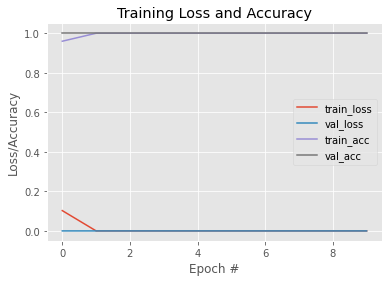

In [14]:
epochs = 10

# Plot training and validation losses
plot_losses(epochs, historyCNN)

### Accuracy on Test set

In [15]:
y_pred_test = merged_model.predict([X_image_test, X_feat_test])

y_pred_test = np.argmax(y_pred_test, axis=1)

Y_image_test = np.argmax(Y_image_test, axis=1)

accuracy_score(Y_image_test, y_pred_test)

1.0

### Create and Train Baseline model for 10 epochs

In [22]:
model = baseline_model(image_input)
historyBaseline = model.fit(X_image_train, Y_image_train, epochs=10, validation_split=0.25)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 94, 94, 64)        1792      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30976)             0   

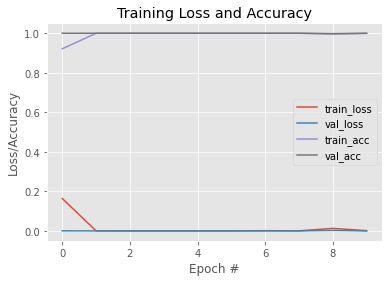

In [19]:
epochs = 10
plot_losses(epochs, historyBaseline)

### Accuracy on Test set

In [21]:
y_pred_test_baseline = model.predict(X_image_test)

y_pred_test_baseline = np.argmax(y_pred_test_baseline, axis=1)

accuracy_score(Y_image_test, y_pred_test_baseline)

1.0

### Test Model on a Diferent Dataset

In [59]:
img_path = "C:\\Users\\mihir\\Machine Learning\\Project\\Face_Mask_Detection\\Test_Data\\dataset"

new_images = read_image_dataset(img_path)

new_X_image, new_X_feat, new_T = create_dataset(new_images)

In [77]:
y_pred_test = merged_model.predict(new_X_image)

y_pred_test = np.argmax(y_pred_test, axis=1)

Y_image_test = np.argmax(new_T, axis=1)

accuracy_score(Y_image_test, y_pred_test)

### Save Models

In [ ]:
model.save("Model_1.h5")

In [ ]:
merged_model.save("MergedModel_1.h5")

### Testing Model on Live Video using Webcam

In [82]:
import cv2
import numpy as np
from keras.models import load_model

model=load_model("./MergedModel_1.h5")
results={0:'without mask',1:'mask'}
GR_dict={0:(0,0,255),1:(0,255,0)}
rect_size = 4
cap = cv2.VideoCapture(0) 
haarcascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
while True:
    (rval, im) = cap.read()
    im=cv2.flip(im,1,1) 
    img_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    rerect_size = cv2.resize(im, (im.shape[1] // rect_size, im.shape[0] // rect_size))
    faces = haarcascade.detectMultiScale(rerect_size)
    # Create cascade classifiers
    face_cascade, eye_cascade, nose_cascade, mouth_cascade = get_cascades()

    # Detect eys, nose and mouth in image
    eyes = eye_cascade.detectMultiScale(img_gray, 1.2, 4)
    nose = nose_cascade.detectMultiScale(img_gray, 1.3, 5)
    mouth = mouth_cascade.detectMultiScale(img_gray, 1.5, 11)
    
    x_feat = []
    if len(eyes) > 0:
        x_feat.append(1)
    else:
        x_feat.append(0)


    if len(nose) > 0:
        x_feat.append(1)
    else:
        x_feat.append(0)


    if len(mouth) > 0:
        x_feat.append(1)
    else:
        x_feat.append(0)
    
    x_feat = np.array(x_feat).reshape(1, 3)
    for f in faces:
        (x, y, w, h) = [v * rect_size for v in f] 
        
        face_img = im[y:y+h, x:x+w]
        rerect_sized=cv2.resize(face_img,(96,96))
        normalized=rerect_sized/255.0
        reshaped=np.reshape(normalized,(1,96,96,3))
        reshaped = np.vstack([reshaped])
        result=model.predict([reshaped, x_feat])
        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),GR_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),GR_dict[label],-1)
        cv2.putText(im, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    
    if key == 27: 
        break
cap.release()
cv2.destroyAllWindows()